In [1]:
!pip install scikit-learn scipy plotly statsmodels

In [2]:
!pip install scikeras

In [3]:
!pip install seaborn

In [21]:
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.losses import Huber, MeanAbsoluteError, MAPE, MAE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
from scipy.stats import poisson
import pandas as pd
import json
import csv
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import re
import ast
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import MaxPooling1D, Flatten, LSTM, Bidirectional, Dense, Dropout, Conv1D, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import MeanAbsolutePercentageError, RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import set_epsilon
from tensorflow import keras
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [8]:
df = pd.read_csv("./data/hanoi_data.csv", parse_dates=['Date'], dayfirst=True)
df = df[(df['Date'] >= '2021-04-5') & (df['Date'] <= '2021-10-19')]
df.tail(5)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15856\3032666805.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("./data/hanoi_data.csv", parse_dates=['Date'], dayfirst=True)


,Date,daily_cases,retail_and_recreation,grocery_and_pharmacy,parks_change,transit_stations,workplaces,residential_change
608,2021-10-15,88.0,-50.0,-33.0,-56.0,-70.0,-29.0,13.0
609,2021-10-16,239.0,-34.0,-10.0,-41.0,-63.0,-29.0,11.0
610,2021-10-17,158.0,-20.0,8.0,-18.0,-58.0,-31.0,5.0
611,2021-10-18,218.0,-44.0,-24.0,-45.0,-66.0,-23.0,10.0
612,2021-10-19,202.0,-29.0,-2.0,-28.0,-58.0,-16.0,7.0


### Data preparation

In [29]:
#@title data preparation, sequence_length = 7, only normalize the training set
feature_columns = df.columns.difference(['Date'])
X_data = df['daily_cases'].values
y_data = df['daily_cases'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=10/len(df), random_state=42, shuffle=False)

# Normalize the data using only the training data
scaler_X_train = StandardScaler()
scaler_y_train = StandardScaler()
scaler_X_test = StandardScaler()
scaler_y_test = StandardScaler()

X_train_scaled = scaler_X_train.fit_transform(X_train.reshape(-1, 1))
y_train_scaled = scaler_y_train.fit_transform(y_train.reshape(-1, 1))
X_test_scaled = scaler_X_test.fit_transform(X_test.reshape(-1, 1))
y_test_scaled = scaler_y_test.fit_transform(y_test.reshape(-1, 1))

def create_sequences(features, target, sequence_length):
    sequences = []
    labels = []
    for i in range(len(features) - sequence_length):
        sequence = features[i:i + sequence_length]
        label = target[i + sequence_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 3
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled.reshape(-1,1), sequence_length)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], 1)

print(X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape)

IndexError: index 188 is out of bounds for axis 0 with size 188

## Building model

### LSTM

In [39]:
#@title model architecture

lstm_model = Sequential()
lstm_model.add(LSTM(100, dropout=0.2, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dense(8, 'relu'))
lstm_model.add(Dense(1, 'linear'))
keras.backend.set_epsilon(1)
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
lstm_model.summary()


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,617 (162.57 KB)

 Trainable params: 41,617 (162.57 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Import necessary modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
import tensorflow.keras.backend as K
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define a function to create the Keras model
def create_model():
    model = Sequential()
    model.add(LSTM(100, dropout=0.2, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))
    K.set_epsilon(1)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
    return model

# Wrap the Keras model using KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the parameter grid
batch_size = [8, 16, 32]
epochs = [200, 300, 500]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Perform Grid Search with appropriate scoring for regression
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='neg_mean_absolute_error', error_score='raise')

# Check shapes and data types
print(X_train_seq.shape)
print(y_train_seq.shape)
print(X_train_seq.dtype if hasattr(X_train_seq, 'dtype') else "Not a DataFrame")
print(y_train_seq.dtype if hasattr(y_train_seq, 'dtype') else "Not a Series")

# Try a single fit to see if it works
try:
    single_model = create_model()
    single_model.fit(X_train_seq, y_train_seq, epochs=1, batch_size=8)
    print("Single fit successful")
except ValueError as e:
    print(f"Single fit ValueError: {e}")

# Fit the grid search
try:
    grid_result = grid.fit(X_train_seq, y_train_seq)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
except ValueError as e:
    print(f"GridSearchCV ValueError: {e}")


(185, 3, 1)
(185, 1)
float64
float64


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7407 - mean_absolute_percentage_error: 57.3711
Single fit successful


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Best: -0.455854 using {'batch_size': 32, 'epochs': 200}


In [ ]:
grid_result = grid.fit(X_train_seq, y_train_seq)

# Print the best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [36]:
#@title training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = lstm_model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.7031 - mean_absolute_percentage_error: 58.7599 - val_loss: 0.7021 - val_mean_absolute_percentage_error: 57.8116
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7335 - mean_absolute_percentage_error: 58.7437 - val_loss: 0.6651 - val_mean_absolute_percentage_error: 55.2688
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6624 - mean_absolute_percentage_error: 56.9920 - val_loss: 0.6297 - val_mean_absolute_percentage_error: 52.8160
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6609 - mean_absolute_percentage_error: 55.8737 - val_loss: 0.5964 - val_mean_absolute_percentage_error: 50.5550
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6319 - mean_absolute_percentage_error: 54.5658 - val_loss: 0.5723 - val_mean_absolute_percentage_error: 48.8794
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6820 - mean_absolute_percentage_error: 54.1724 - val_loss: 0.5521 - val_mean_abs

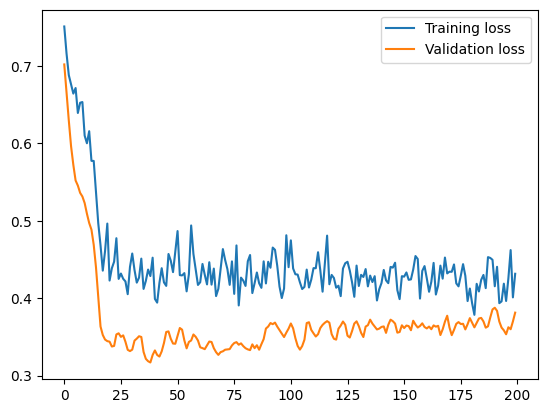

In [37]:
#@title plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [25]:
#@title visualization the result
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

y_pred_train = model.predict(X_train_seq).reshape(-1,1)
y_pred_test = model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

# Add training data traces
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

# Add testing data traces
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

# Update layout
fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )

# Show the plot
fig.show()



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [38]:
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


MAE: 0.6132723689079285
RMSE: 0.870731770992279
R² score: -0.16893494129180908


In [27]:
model.save('./checkpoints/LSTM.h5')


### RNN

In [42]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(100, dropout=0.2, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
rnn_model.add(Dense(8, activation='relu'))
rnn_model.add(Dense(1, activation='linear'))
K.set_epsilon(1)
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
rnn_model.summary()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 100)            │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,017 (43.04 KB)

 Trainable params: 11,017 (43.04 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
#@title training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = rnn_model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.7291 - mean_absolute_percentage_error: 58.1423 - val_loss: 0.3122 - val_mean_absolute_percentage_error: 24.3994
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5164 - mean_absolute_percentage_error: 40.1212 - val_loss: 0.2876 - val_mean_absolute_percentage_error: 22.9586
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4737 - mean_absolute_percentage_error: 38.4320 - val_loss: 0.4204 - val_mean_absolute_percentage_error: 33.0377
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5591 - mean_absolute_percentage_error: 41.1340 - val_loss: 0.4166 - val_mean_absolute_percentage_error: 31.4173
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4539 - mean_absolute_percentage_error: 32.5369 - val_loss: 0.3994 - val_mean_absolute_percentage_error: 30.2025
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4012 - mean_absolute_percentage_error: 30.4777 - val_loss: 0.3565 - val_mean_abs

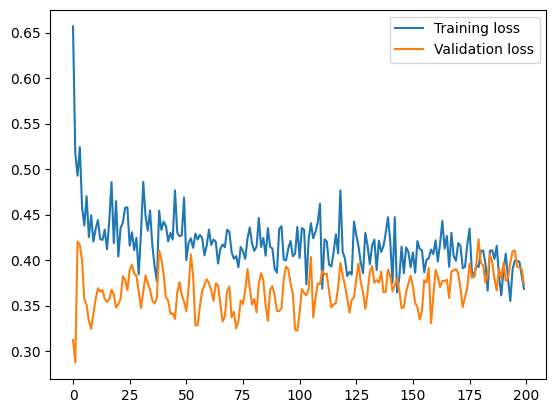

In [45]:
#@title plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [46]:
#@title visualization the result
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

y_pred_train = rnn_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = rnn_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

# Add training data traces
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

# Add testing data traces
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

# Update layout
fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )

# Show the plot
fig.show()



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [47]:
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


MAE: 0.7006569504737854
RMSE: 0.9111506938934326
R² score: -0.279976487159729


In [49]:
rnn_model.save("./checkpoints/rnn.h5")

### GRU

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 100)            │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,717 (123.89 KB)

 Trainable params: 31,717 (123.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.7010 - mean_absolute_percentage_error: 57.8407 - val_loss: 0.6410 - val_mean_absolute_percentage_error: 50.2216
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6655 - mean_absolute_percentage_error: 50.3639 - val_loss: 0.5607 - val_mean_absolute_percentage_error: 42.2610
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5353 - mean_absolute_percentage_error: 40.2441 - val_loss: 0.5067 - val_mean_absolute_percentage_error: 36.9734
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5265 - mean_absolute_percentage_error: 38.1134 - val_loss: 0.5073 - val_mean_absolute_percentage_error: 37.3344
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6263 - mean_absolute_percentage_error: 42.3937 - val_loss: 0.4873 - val_mean_absolute_percentage_error: 35.7706
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4904 - mean_absolute_percentage_error: 36.5357 - val_loss: 0.4776 - val_mean_abs

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


MAE: 0.6038687825202942
RMSE: 0.8630304932594299
R² score: -0.14834880828857422


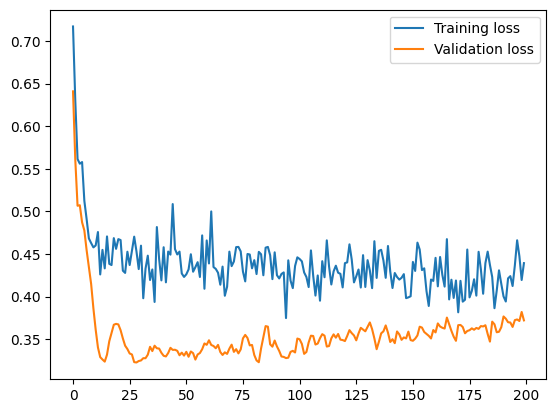

In [51]:
gru_model = Sequential()
gru_model.add(GRU(100, dropout=0.2, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
gru_model.add(Dense(8, activation='relu'))
gru_model.add(Dense(1, activation='linear'))
K.set_epsilon(1)
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
gru_model.summary()


# training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = gru_model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32, validation_split=0.2, verbose=1)


# plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


# visualization the result
y_pred_train = gru_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = gru_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )
fig.show()


# Compute score metrics
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


# save the model
gru_model.save("./checkpoints/gru.h5")


### bidirectional LSTM

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,217 (325.07 KB)

 Trainable params: 83,217 (325.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.7575 - mean_absolute_percentage_error: 59.5445 - val_loss: 0.5796 - val_mean_absolute_percentage_error: 44.7844
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5052 - mean_absolute_percentage_error: 40.1020 - val_loss: 0.4414 - val_mean_absolute_percentage_error: 32.6570
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5058 - mean_absolute_percentage_error: 37.4361 - val_loss: 0.3898 - val_mean_absolute_percentage_error: 29.3021
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4177 - mean_absolute_percentage_error: 32.1575 - val_loss: 0.3502 - val_mean_absolute_percentage_error: 26.8652
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5064 - mean_absolute_percentage_error: 33.8279 - val_loss: 0.3251 - val_mean_absolute_percentage_error: 25.1225
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4423 - mean_absolute_percentage_error: 34.2568 - val_loss: 0.3224 - v

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


MAE: 0.6952709555625916
RMSE: 0.8913171887397766
R² score: -0.22485899925231934


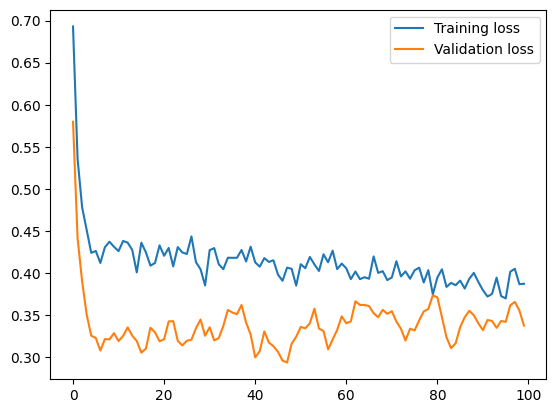

In [52]:
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(100, dropout=0.2, return_sequences=False), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
bilstm_model.add(Dense(8, activation='relu'))
bilstm_model.add(Dense(1, activation='linear'))
K.set_epsilon(1)
bilstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
bilstm_model.summary()


# training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = bilstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=16, validation_split=0.2, verbose=1)


# plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


# visualization the result
y_pred_train = bilstm_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = bilstm_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )
fig.show()


# Compute score metrics
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


# save the model
bilstm_model.save("./checkpoints/bilstm.h5")


### stacked LSTM

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 3, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,417 (278.97 KB)

 Trainable params: 71,417 (278.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.7101 - mean_absolute_percentage_error: 58.4267 - val_loss: 0.6719 - val_mean_absolute_percentage_error: 54.1164
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6314 - mean_absolute_percentage_error: 51.9191 - val_loss: 0.5414 - val_mean_absolute_percentage_error: 41.9033
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5314 - mean_absolute_percentage_error: 40.7307 - val_loss: 0.4512 - val_mean_absolute_percentage_error: 34.1830
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5000 - mean_absolute_percentage_error: 34.7240 - val_loss: 0.4205 - val_mean_absolute_percentage_error: 32.0863
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5190 - mean_absolute_percentage_error: 35.7823 - val_loss: 0.3866 - val_mean_absolute_percentage_error: 29.6105
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4878 - mean_absolute_percentage_error: 34.2792 - val_loss: 0.3521 - val_

MAE: 0.6555348634719849
RMSE: 0.8973724246025085
R² score: -0.24155795574188232


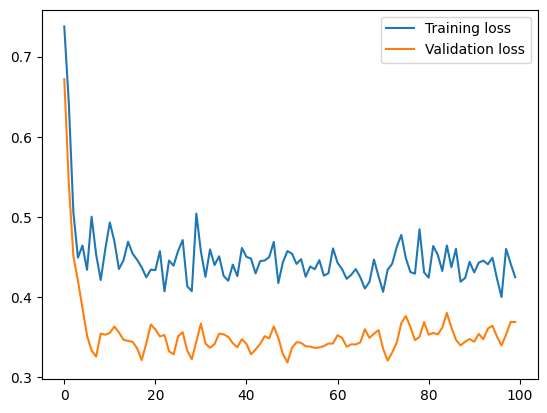

In [54]:
stacked_lstm_model = Sequential()
stacked_lstm_model.add(LSTM(100, dropout=0.2, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
stacked_lstm_model.add(LSTM(50, dropout=0.2, return_sequences=False))  # No need for input_shape here
stacked_lstm_model.add(Dense(8, activation='relu'))
stacked_lstm_model.add(Dense(1, activation='linear'))
K.set_epsilon(1)
stacked_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
stacked_lstm_model.summary()


# training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = stacked_lstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=16, validation_split=0.2, verbose=1)


# plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


# visualization the result
y_pred_train = stacked_lstm_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = stacked_lstm_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )
fig.show()


# Compute score metrics
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


# save the model
stacked_lstm_model.save("./checkpoints/stacked_lstm.h5")


### Convolutional LSTM

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_23 (Conv1D)              │ (None, 2, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 2, 100)         │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 1, 32)          │         6,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,657 (283.82 KB)

 Trainable params: 72,657 (283.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 - 2s - 210ms/step - loss: 0.6926 - mean_absolute_percentage_error: 55.4818 - val_loss: 0.5561 - val_mean_absolute_percentage_error: 44.5000
Epoch 2/100
10/10 - 0s - 8ms/step - loss: 0.4995 - mean_absolute_percentage_error: 37.4084 - val_loss: 0.3668 - val_mean_absolute_percentage_error: 28.2681
Epoch 3/100
10/10 - 0s - 7ms/step - loss: 0.4402 - mean_absolute_percentage_error: 33.3172 - val_loss: 0.3004 - val_mean_absolute_percentage_error: 23.8119
Epoch 4/100
10/10 - 0s - 7ms/step - loss: 0.4193 - mean_absolute_percentage_error: 32.2232 - val_loss: 0.3214 - val_mean_absolute_percentage_error: 25.1928
Epoch 5/100
10/10 - 0s - 8ms/step - loss: 0.4088 - mean_absolute_percentage_error: 30.2869 - val_loss: 0.3320 - val_mean_absolute_percentage_error: 25.7069
Epoch 6/100
10/10 - 0s - 8ms/step - loss: 0.3896 - mean_absolute_percentage_error: 28.9014 - val_loss: 0.3025 - val_mean_absolute_percentage_error: 23.6465
Epoch 7/100
10/10 - 0s - 7ms/step - loss: 0.4113 - mean_absolu

MAE: 0.6487508416175842
RMSE: 0.8598552942276001
R² score: -0.13991451263427734


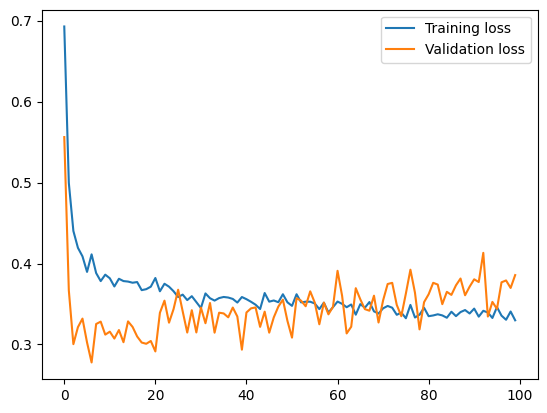

In [28]:
conv_lstm_model = Sequential()
conv_lstm_model.add(Conv1D(64, 2, activation='relu', input_shape=(3, 1)))  # Use kernel size 2 to fit the small input
conv_lstm_model.add(MaxPooling1D(pool_size=1))  # Pooling size 1 to prevent negative dimensions
conv_lstm_model.add(LSTM(100, return_sequences=True))
conv_lstm_model.add(Dropout(0.2))
conv_lstm_model.add(Conv1D(32, 2, activation='relu'))  # Adjust kernel size to fit the reduced dimensions
conv_lstm_model.add(MaxPooling1D(pool_size=1))  # Pooling size 1 to prevent negative dimensions
conv_lstm_model.add(Flatten())
conv_lstm_model.add(Dense(units=1))
set_epsilon(1)
conv_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])

conv_lstm_model.summary()


# training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = conv_lstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=16, validation_split=0.2, verbose=2)


# plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


# visualization the result
y_pred_train = conv_lstm_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = conv_lstm_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )
fig.show()


# Compute score metrics
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


# save the model
conv_lstm_model.save("./checkpoints/conv_lstm.h5")
